In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import math
import tensorflow as tf

In [9]:
# Load your dataset. Uncomment the index of your choice
sp500 = yf.Ticker("^GSPC")    # For S&P500
# sp500 = yf.Ticker("NDAQ")    # For NASDAQ
# sp500 = yf.Ticker("AAPL")    # For Apple
sp500 = sp500.history(period="max")
sp500.to_csv("sp500.csv")
sp500.index = pd.to_datetime(sp500.index)

<Axes: xlabel='Date'>

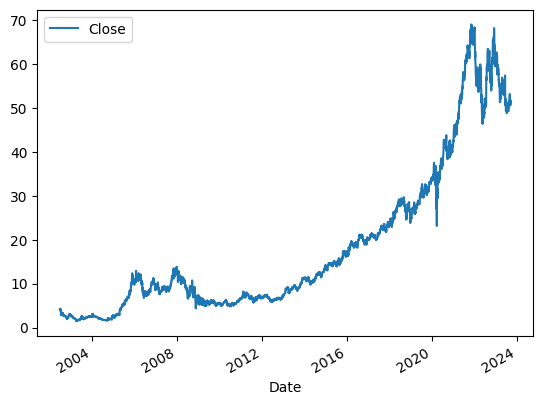

In [10]:
# Plot 'Close' stock prices for whole timeline
sp500.plot.line(y="Close", use_index=True)

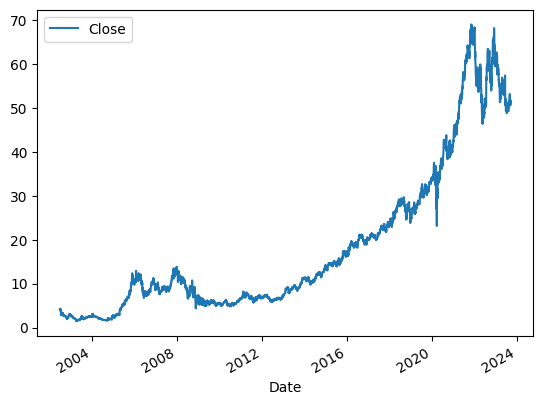

In [11]:
# Only use values after the year 1990
sp500 = sp500.loc["1990-01-01":].copy()
sp500.plot.line(y="Close", use_index=True)    # Plot the 'Close' data again, starting from later date

# Extract only the closing prices
prices = sp500['Close'].values.reshape(-1, 1)

In [12]:
# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

In [13]:
# Use only initial 95% of data for training, the rest for testing
train_size = int(len(prices_scaled) * 0.95)
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size:]

In [14]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length]
        sequences.append((sequence, target))
    return np.array(sequences)

sequence_length = 15  # How many days we want to look back for training and giving a prediction
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

<ipython-input-14-4bf7592f7b96>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


In [15]:
model = Sequential()

# A shallow NN
# Give RSME of (train, test) = (43.79, 132.70)
# A shalow network is NOT good
# model.add(LSTM(units=50, input_shape=(sequence_length, 1)))
# model.add(Dense(units=1))

# A deeper NN
# Train Score: 35.98 RMSE
# Test Score: 102.16 RMSE
# With 100 Epochs
# Train Score: 29.25 RMSE
# Test Score: 71.73 RMSE
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Modify this line to convert the sequences to a tuple of NumPy arrays
train_input = np.array([sequence for sequence, _ in train_sequences])
train_target = np.array([target for _, target in train_sequences])

# Then, use train_input and train_target in model.fit
model.fit(train_input, train_target, epochs=40, batch_size=64)

Epoch 1/40
80/80 [==============================] - 10s 6ms/step - loss: 0.0074
Epoch 2/40
80/80 [==============================] - 0s 5ms/step - loss: 1.5596e-04
Epoch 3/40
80/80 [==============================] - 0s 6ms/step - loss: 1.5140e-04
Epoch 4/40
80/80 [==============================] - 0s 5ms/step - loss: 1.5381e-04
Epoch 5/40
80/80 [==============================] - 0s 6ms/step - loss: 1.4653e-04
Epoch 6/40
80/80 [==============================] - 1s 6ms/step - loss: 1.5468e-04
Epoch 7/40
80/80 [==============================] - 0s 5ms/step - loss: 1.4464e-04
Epoch 8/40
80/80 [==============================] - 0s 6ms/step - loss: 1.4458e-04
Epoch 9/40
80/80 [==============================] - 0s 6ms/step - loss: 1.3862e-04
Epoch 10/40
80/80 [==============================] - 0s 6ms/step - loss: 1.3252e-04
Epoch 11/40
80/80 [==============================] - 1s 7ms/step - loss: 1.2994e-04
Epoch 12/40
80/80 [==============================] - 1s 8ms/step - loss: 1.2172e-04
Epoc

In [17]:
# Modify this line to convert the sequences to a tuple of NumPy arrays
test_input = np.array([sequence for sequence, _ in test_sequences])
test_target = np.array([target for _, target in test_sequences])

test_loss = model.evaluate(test_input, test_target)

# Make predictions on the test set
predicted_prices = model.predict(test_input)

# Inverse transform the scaled predictions to original prices
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 1s 3ms/step


In [18]:
# Get the models predicted price values
train_predict = model.predict(train_input)
test_predict = model.predict(test_input)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

8/8 [==============================] - 0s 3ms/step


In [19]:
# Get the root mean squared error (RMSE)
rmse_train = np.sqrt(np.mean(((train_predict - scaler.inverse_transform(train_target)) ** 2)))
rmse_test  = np.sqrt(np.mean(((test_predict  - scaler.inverse_transform(test_target))  ** 2)))

print('Train Score: %.2f RMSE' % (rmse_train))
print('Test Score: %.2f RMSE' % (rmse_test))

Train Score: 0.53 RMSE
Test Score: 1.17 RMSE


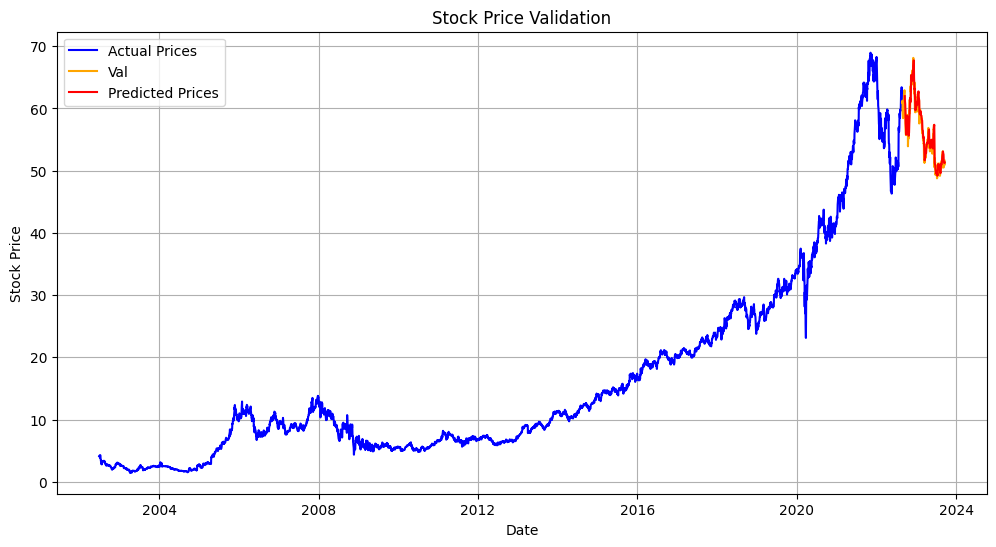

In [20]:
# Plot the actual historical data and predicted future prices
plt.figure(figsize=(12, 6))
# plt.plot(sp500['Date'], sp500['Close'], label='Historical Prices', color='blue')
# plt.plot(sp500.index, sp500['Close'], label='Historical Prices', color='black')   # Works fine
plt.plot(sp500.index[:train_size], prices[:train_size], label='Actual Prices', color='blue')
plt.plot(sp500.index[train_size:], prices[train_size:], label='Val', color='orange')
plt.plot(sp500.index[train_size+sequence_length:train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Validation')
plt.legend()
plt.grid()
plt.show()

In [21]:
predicted_prices.shape
sp500.index[train_size:].shape

(267,)

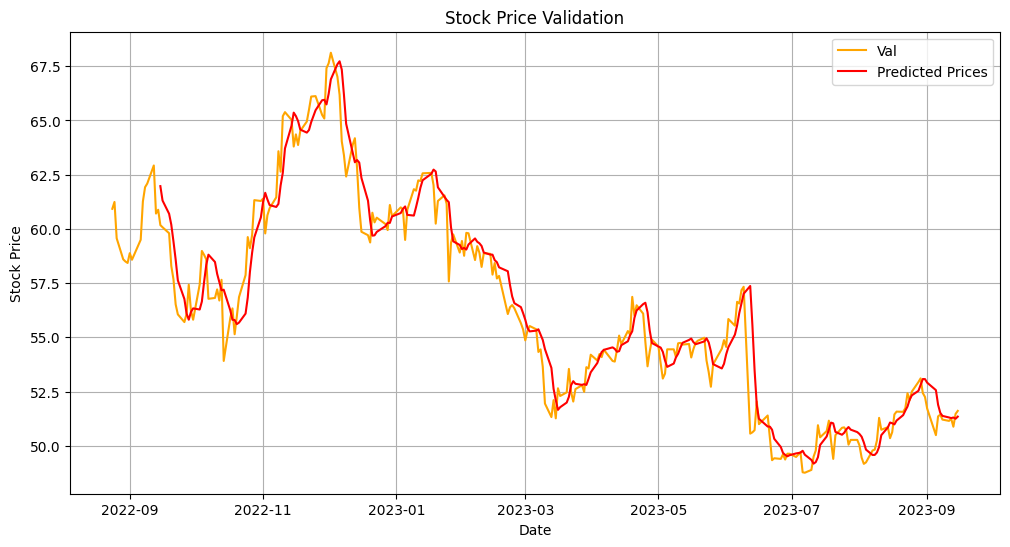

In [22]:
# Plot the actual historical data and predicted future prices
plt.figure(figsize=(12, 6))
# plt.plot(sp500['Date'], sp500['Close'], label='Historical Prices', color='blue')
# plt.plot(sp500.index, sp500['Close'], label='Historical Prices', color='black')                 # Works fine
# plt.plot(sp500.index[:train_size], prices[:train_size], label='Actual Prices', color='blue')    # Works fine, but intentionaly removed here
plt.plot(sp500.index[train_size:], prices[train_size:], label='Val', color='orange')
plt.plot(sp500.index[train_size+sequence_length : train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')
# plt.plot(sp500.index[train_size : train_size+predicted_prices.size], predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Validation')
plt.legend()
plt.grid()
plt.show()

# Future prediction

In [23]:
# Get the most recent sequence from your test data
last_sequence = test_input[-1]

print(test_input.shape)
print(last_sequence.shape)

(252, 15, 1)
(15, 1)


In [24]:
# Number of future time steps to predict
future_time_steps = 30  # Adjust as needed

future_predictions = []

for _ in range(future_time_steps):
    # Predict the next price
    next_price = model.predict(last_sequence.reshape(1, sequence_length, 1))

    # Append the predicted price to the list
    future_predictions.append(next_price[0, 0])

    # Update the last_sequence by removing the first element and adding the predicted price
    last_sequence = np.concatenate((last_sequence[1:], next_price), axis=None)

1/1 [==============================] - 0s 18ms/step


In [25]:
# Inverse transform the scaled predictions to original prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

<ipython-input-26-7b518b178c2a>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_axis = pd.date_range(start=sp500.index[-1], periods=future_time_steps + 1, closed='right')


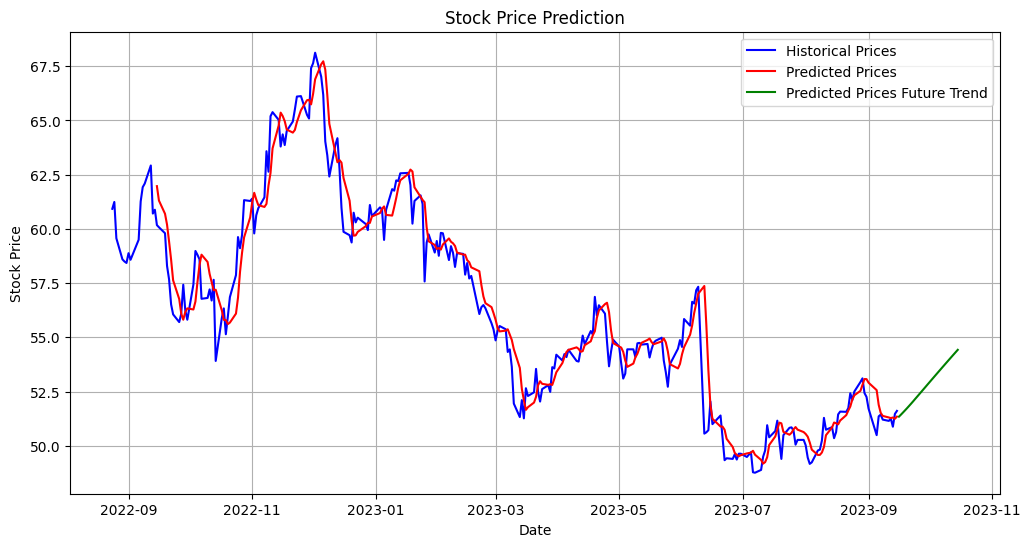

In [26]:
# Create a time axis for future predictions
time_axis = pd.date_range(start=sp500.index[-1], periods=future_time_steps + 1, closed='right')

# Plot the actual historical data and predicted future prices
plt.figure(figsize=(12, 6))
# plt.plot(sp500.index, sp500['Close'], label='Historical Prices', color='blue')
plt.plot(sp500.index[train_size:], sp500['Close'][train_size:], label='Historical Prices', color='blue')
# plt.plot(time_axis[1:], future_predictions, label='Predicted Prices', color='red')
plt.plot(sp500.index[train_size+sequence_length:train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')
plt.plot(time_axis[:], future_predictions, label='Predicted Prices Future Trend', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()

# Backtesting

<ipython-input-27-0275af1f582e>:42: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, closed='right')
<ipython-input-27-0275af1f582e>:42: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, closed='right')
<ipython-input-27-0275af1f582e>:42: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, closed='right')
<ipython-input-27-0275af1f582e>:42: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, closed='right')
<ipython-input-27-0275af1f582e>:42: FutureWarning: Argument `closed` is 

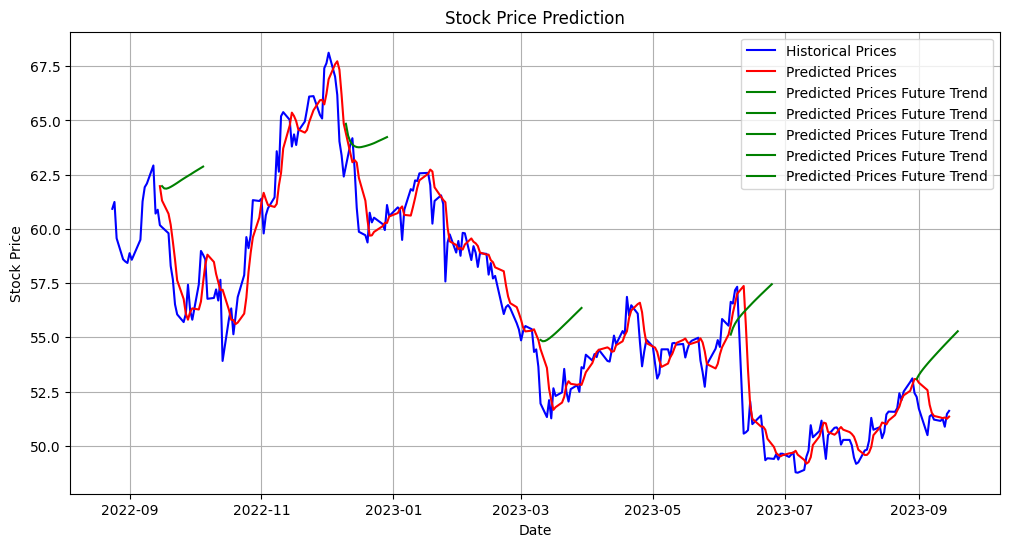

In [27]:
# Multiple predictions from multiple points

# Number of future time steps to predict
future_time_steps = 20  # Adjust as needed

# How many days we want our predictions to starts from
start_day = 0
interval_gap = 60

fig = plt.figure(figsize=(12, 6))

# Plot the actual historical data and predicted future prices

# plt.plot(sp500.index, sp500['Close'], label='Historical Prices', color='blue')
fig = plt.plot(sp500.index[train_size:], sp500['Close'][train_size:], label='Historical Prices', color='blue')
# plt.plot(time_axis[1:], future_predictions, label='Predicted Prices', color='red')
plt.plot(sp500.index[train_size+sequence_length:train_size+predicted_prices.size+sequence_length], predicted_prices, label='Predicted Prices', color='red')     # Works  # Comment later

for i in range(start_day, test_input.shape[0], interval_gap):
    # Get the most recent sequence from your test data
    last_sequence = test_input[i]

    # print(test_input.shape)
    # print(last_sequence.shape)

    future_predictions = []

    for j in range(future_time_steps):
        # Predict the next price
        next_price = model.predict(last_sequence.reshape(1, sequence_length, 1), verbose=0)

        # Append the predicted price to the list
        future_predictions.append(next_price[0, 0])

        # Update the last_sequence by removing the first element and adding the predicted price
        last_sequence = np.concatenate((last_sequence[1:], next_price), axis=None)

    # Inverse transform the scaled predictions to original prices
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Create a time axis for future predictions
    time_axis = pd.date_range(start=sp500.index[train_size+sequence_length+i], periods=future_time_steps + 1, closed='right')

    # if j == future_time_steps - 1:
      # plt.plot(time_axis[:], future_predictions, label='Predicted Prices Future Trend', color='green') # sequence_length
    plt.plot(time_axis[:], future_predictions, label='Predicted Prices Future Trend', color='green')
    # else:
    #   plt.plot(time_axis[:], future_predictions, color='green')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()